# MLOps with Amazon SageMaker: Getting Started

> *This notebook works well with the `Python 3 (Data Science)` kernel on SageMaker Studio*

Welcome to this short workshop on MLOps with Amazon SageMaker!

First we'll install a couple of useful packages for later, in case they're not already available in the kernel environment:

In [1]:
!pip install altair

     |████████████████████████████████| 727 kB 41.8 MB/s eta 0:00:01


## Locating our project environment

In [2]:
%load_ext autoreload
%autoreload 2
import util

project_id = "creditmodel"  # TODO: Change this if you set a different Project ID in service catalog!

project_config = util.project.init(project_id)
project_config

<util.project.ProjectSession(
  project_id=creditmodel,
  role=arn:aws:iam::024103970757:role/mlopsintro-SageMakerExecutionRole-TK3Y6YQI58VH,
  raw_bucket=creditmodel-mlrawdata-024103970757-ap-northeast-1,
  sandbox_bucket=creditmodel-mlsandbox-024103970757-ap-northeast-1
) at 0x7f1ad8a83850>

In [3]:
print(f"Raw data bucket: s3://{project_config.raw_bucket}/")
print(f"Sandbox bucket: s3://{project_config.sandbox_bucket}/")

Raw data bucket: s3://creditmodel-mlrawdata-024103970757-ap-northeast-1/
Sandbox bucket: s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/


## Preparing data with SageMaker Data Wrangler

### Create the data flow

(Old initial quick model got to 0.708 F1 before we ran ordinal encodes)

(Goes down to 0.692 raw after change to mapping and up to 0.703 after all ordinals, before any one-hots)

- Open `credit-data.flow`
- Select the input CSV from the raw data bucket as source
- Create analysis: `missing.py`
- Create analysis: Initial quick model
- `credit_risk` strings to int(bool) and move to front `cast(credit_risk == "bad" as int)`, move `credit_default` to start, drop `credit_risk`
- (Unguided) do same for `telephone` -> `has_telephone` and `foreign_worker` -> `is_foreign_worker` (no need to bring to front)
- `checking_acct_status` extract `\d+` to get the band number, fill with 0 for "no account" -> `checking_acct_band`
- (Unguided) do same for `savings_status` -> `savings_band` and `highest_property` -> `highest_property_band` (doesn't need filling)
- Split `marital_status_and_gender` on ` : `
    - 'Matches' for male -> gender_is_male
    - Do we need to cast this gender field?
    - Split on ` : ` up to 2 splits
    - Extract second one to `marital_status_text` text field
    - *Featurize Text > Vectorize* with custom tokenizer on regex `/`, no IDF, output as `marital_status` columns (not vector)
    - Drop `marital_status_text`
- One-hot the `purpose` field
- Either one-hot or custom encode these fields:
    - `other_parties`? (none / co-applicant / guarantor)
    - `other_installment_plans` (bank / stores / none)
    - `housing` (rent / own / for free)

Train-Test Split (Custom SQL steps):
- `random(1337)` as `random_01`
- `row_number() over (partition by credit_default order by random_01)` as `stratum_row_num`
- `max(stratum_row_num) over (partition by credit_default)` as `stratum_size`
- `stratum_row_num / stratum_size` as `stratum_rank_pct`
- `case when (stratum_rank_pct < 0.7) then "train" when (stratum_rank_pct < 0.85) then "validation" else "test" end` as `dataset`

Wrapping up:
- Create target leakage report

Extension:
- `credit_amount` logscale via `log10(credit_amount)`?


Finally:
- Export the final node to the feature store?

In [132]:
container_uri = # TODO: Get from the example notebook
target_output_name = # TODO: Get from 'output_name' in the example notebook

In [133]:
import sagemaker
smsess = sagemaker.Session()
region = smsess.boto_region_name
print(region)

ap-northeast-1


In [134]:
processor = sagemaker.Processor(
    role=sagemaker.get_execution_role(),  # Just use the current notebook's IAM role
    image_uri=container_uri,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
)

In [135]:
processing_job_name = util.uid.append_timestamp("credit-flow")
print(f"Creating Processing job with name {processing_job_name}")

flow_upload_s3uri = f"s3://{project_config.sandbox_bucket}/data-wrangler/{processing_job_name}/flow/credit-data.flow"
print(f"Uploading flow file to {flow_upload_s3uri}")

# Outputs automatically create jobname/outputnames subfolders:
base_output_s3uri = f"s3://{project_config.sandbox_bucket}/data-wrangler"
print(f"Storing results to {flow_output_s3uri}")

processor.run(
    inputs=util.wrangler.create_processing_inputs("credit-data.flow", flow_upload_s3uri),
    outputs=[
        util.wrangler.create_s3_output(target_output_name, base_output_s3uri),
#         util.wrangler.create_featurestore_output(
#             target_output_name,
#             feature_group_name,
#         )
    ],
    arguments=util.wrangler.create_container_arguments(target_output_name),
    wait=True,
    #logs=False,
    job_name=processing_job_name,
)

Creating Processing job with name credit-flow-2021-03-12-03-14-57
Uploading flow file to s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/data-wrangler/credit-flow-2021-03-12-03-14-57/flow/credit-data.flow
Storing results to s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/data-wrangler/credit-flow-2021-03-10-14-52-24/006869ca-e5fe-4c4d-b290-c1fe8127513b/default/
Uploaded credit-data.flow to s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/data-wrangler/credit-flow-2021-03-12-03-14-57/flow/credit-data.flow

Job Name:  credit-flow-2021-03-12-03-14-57
Inputs:  [{'InputName': 'flow', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://creditmodel-mlsandbox-024103970757-ap-northeast-1/data-wrangler/credit-flow-2021-03-12-03-14-57/flow/credit-data.flow', 'LocalPath': '/opt/ml/processing/flow', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'german.csv', 'AppManaged': False, 'S3Input': {

In [136]:
flow_output_s3uri = f"{base_output_s3uri}/{processing_job_name}/{target_output_name.replace('.', '/')}/"
print(flow_output_s3uri)
!aws s3 ls $flow_output_s3uri

s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/
2021-03-12 03:20:38        839 part-00000-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv
2021-03-12 03:20:38      43345 part-00001-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv
2021-03-12 03:20:38      99965 part-00003-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv


In [137]:
df = util.data.dataframe_from_s3_folder(flow_output_s3uri)
df.head()

Loading data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/part-00000-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv
Loading data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/part-00001-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv
Loading data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/part-00003-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv


,credit_default,duration_months,credit_history,credit_amount,present_employment_yrs_lt,installment_rate_disp_income_pct,present_residence_since,age_in_years,n_existing_credits_this_bank,job_type,...,other_parties_none,other_parties_guarantor,other_parties_coapplicant,other_installment_plans_none,other_installment_plans_bank,other_installment_plans_stores,housing_own,housing_rent,housing_for_free,dataset
0,1,36,3,2225,10,4,4,57,2,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,train
1,1,12,0,1082,4,4,4,48,2,2,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,train
2,1,27,2,3915,4,4,2,36,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,train
3,1,30,1,7485,0,4,1,53,1,3,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,train
4,1,6,4,3384,4,1,4,44,1,3,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,train


In [138]:
# Check dataset split is OK:
dataset_lens = df.groupby(["dataset"])["credit_default"].count()
dataset_lens / len(df)

dataset
test          0.152
train         0.698
validation    0.150
Name: credit_default, dtype: float64

In [139]:
# Check stratification has worked:
df.groupby(["dataset", "credit_default"])["credit_default"].count() / dataset_lens

dataset     credit_default
test        0                 0.697368
            1                 0.302632
train       0                 0.700573
            1                 0.299427
validation  0                 0.700000
            1                 0.300000
Name: credit_default, dtype: float64

In [140]:
# How about the distribution of non-stratified fields:
df.groupby(["dataset", "gender_is_male"])["gender_is_male"].count() / dataset_lens

dataset     gender_is_male
test        0                 0.328947
            1                 0.671053
train       0                 0.312321
            1                 0.687679
validation  0                 0.280000
            1                 0.720000
dtype: float64

In [141]:
# Hack around Feature Store not being supported on EE platform:
model_datasets_s3uri = f"s3://{project_config.sandbox_bucket}/model-datasets"

model_datasets = util.data.mock_featurestore_dataset_split(
    flow_output_s3uri,
    model_datasets_s3uri,
    dataset_label_col="dataset",
    datasets_with_headers=r"train.*",  # Only include headers on the 'train' set
)

print(f"\nSplit datasets out to:")
model_datasets

Loading data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/part-00000-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv
Loading data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/part-00001-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv
Loading data-wrangler/credit-flow-2021-03-12-03-14-57/e4adff78-b977-4b75-b975-ef25e26f348f/default/part-00003-a0a68684-681c-42c1-a344-fac03278a44c-c000.csv

Split datasets out to:


{'train': ['s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/model-datasets/train/part0.csv'],
 'validation': ['s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/model-datasets/validation/part0.csv'],
 'test': ['s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/model-datasets/test/part0.csv']}

## Training an initial model with SageMaker XGBoost Algorithm

- Query the feature store to realise separate training/val/test sets?
- XGB

In [142]:
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.0-1")
print(training_image)

354813040037.dkr.ecr.ap-northeast-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [143]:
# TODO: Replace '???' with the path where you saved your training file in S3
train_uri = f"{model_datasets_s3uri}/train"
print(f"Training data: {train_uri}")
s3_input_train = sagemaker.inputs.TrainingInput(train_uri, content_type="csv")

# TODO: Replace '???' with the path where you saved your training file in S3
val_uri = f"{model_datasets_s3uri}/validation"
print(f"Validation data: {val_uri}")
s3_input_validation = sagemaker.inputs.TrainingInput(val_uri, content_type="csv")

Training data: s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/model-datasets/train
Validation data: s3://creditmodel-mlsandbox-024103970757-ap-northeast-1/model-datasets/validation


In [144]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type="ml.m5.xlarge",  # type of training instance
    instance_count=1,  # number of instances to be used
    role=sagemaker.get_execution_role(),  # Just use the current notebook's IAM role
    max_run=20*60,  # Maximum allowed active runtime
    use_spot_instances=True,  # Use spot instances to reduce cost
    max_wait=30*60,  # Maximum clock time (including spot delays)
    base_job_name=f"{project_id}-xgboost",
    output_folder=f"s3://{project_config.sandbox_bucket}/model-training",  # TODO: Maybe not respecting this?
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150,  # int: [1,300]
    max_depth=5,  # int: [1,10]
    alpha=2.5,  # float: [0,5]
    eta=0.5,  # float: [0,1]
    objective="binary:logistic",
)

# start a training (fitting) job
estimator.fit({ "train": s3_input_train, "validation": s3_input_validation })

2021-03-12 03:23:19 Starting - Starting the training job.

KeyboardInterrupt: 

## Testing the model with SageMaker Batch Transform

In [166]:
# TODO: Need to save the test file (at least) with no header!

test_data_uri = f"{model_datasets_s3uri}/test"
test_output_uri = f"s3://{project_config.sandbox_bucket}/model-eval/{estimator.latest_training_job.name}"

transformer = estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=test_output_uri,
    accept="text/csv",
    assemble_with="Line",
)

# calls that object's transform method to create a transform job
transformer.transform(
    data=test_data_uri,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line",
    join_source="Input",
    input_filter="$[1:]",
)

# wait=True by default right? Or transformer.wait()

..............................
[2021-03-12:04:09:49:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-12:04:09:49:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-12:04:09:49:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


2021/03/12 04:09:50 [crit] 19#19: *1 conne

In [168]:
!aws s3 ls --recursive $test_output_uri

2021-03-12 04:09:53      23505 model-eval/creditmodel-xgboost-2021-03-12-03-23-19-092/part0.csv.out


In [175]:
colnames = list(filter(lambda c: c != "dataset", df.columns.tolist())) + ["credit_default_pred"]
test_result_df = util.data.dataframe_from_s3_folder(test_output_uri, header=None, names=colnames)
test_result_df.head()

Loading model-eval/creditmodel-xgboost-2021-03-12-03-23-19-092/part0.csv.out


,credit_default,duration_months,credit_history,credit_amount,present_employment_yrs_lt,installment_rate_disp_income_pct,present_residence_since,age_in_years,n_existing_credits_this_bank,job_type,...,other_parties_none,other_parties_guarantor,other_parties_coapplicant,other_installment_plans_none,other_installment_plans_bank,other_installment_plans_stores,housing_own,housing_rent,housing_for_free,credit_default_pred
0,1,12,2,674,7,4,1,20,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.222375
1,1,18,3,1808,7,4,1,22,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.023244
2,1,48,4,5096,4,2,3,30,1,3,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.418617
3,1,12,4,939,7,4,2,28,3,2,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.151963
4,1,48,0,4605,10,3,4,24,2,2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.699565


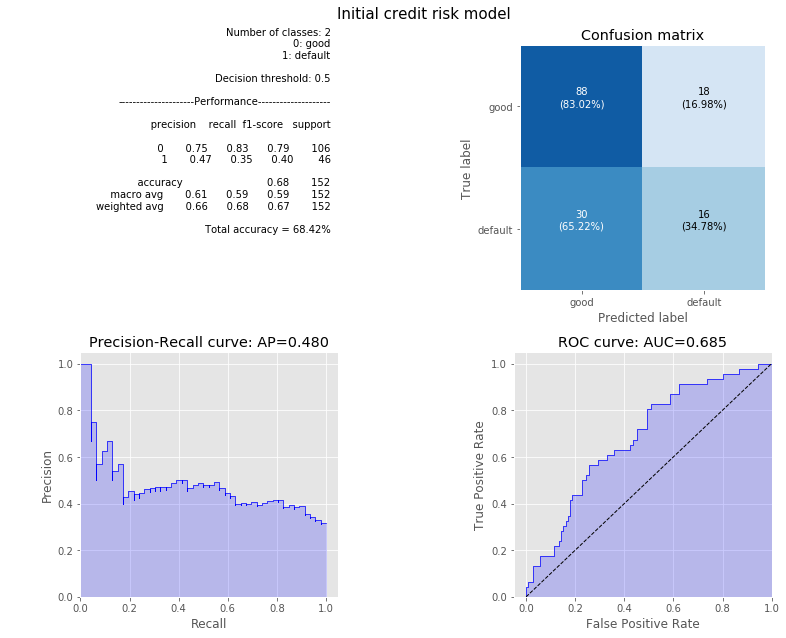

In [177]:
util.plotting.generate_classification_report(
    y_real=test_result_df["credit_default"],
    y_predict_proba=test_result_df["credit_default_pred"],
    decision_threshold=0.5,
    class_names_list=["good", "default"],
    title="Initial credit risk model",
)

## Next steps